In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

import copia

Official name: "Chao1-shared estimator".

Load the datasets:

1. Chivalric narratives (medieval French and Dutch), temporary data:

In [2]:
chivalry = pd.read_excel('../data/FR-DU.xlsx').reset_index(drop=True)
chivalry.columns = ['work', 'S1', 'S2', 'comments']
chivalry = chivalry[['S1', 'S2']]
chivalry['S1'] = chivalry['S1'].astype(int)
chivalry['S2'] = chivalry['S2'].astype(int)
chivalry.head()

,S1,S2
0,6,0
1,1,2
2,1,0
3,0,1
4,0,5


2. Data discussed in:

> Chao, Anne, Chiu Chun‐Huo, Robert K. Colwell, Luiz Fernando S. Magnago, Robin L. Chazdon, and Nicholas J. Gotelli. 2017. Deciphering the Enigma of Undetected Species, Phylogenetic, and Functional Diversity Based on Good‐Turing Theory. *Ecology* 98 (11): 2914–29.

The data (tree species abundance data for the edge and interior habitats in forest fragments of south-eastern Brazil) are borrowed from another study:

> Magnago, L. F. S., D. P. Edwards, F. A. Edwards, A. Magrach, S. V. Martins, and W. F. Laurance. 2014. Functional attributes change but functional richness is unchanged after fragmentation of Brazilian Atlantic forests. *Journal of Ecology* 102:475−485.

This data can be found on Anne Chao's [Github page](https://raw.githubusercontent.com/AnneChao/Good-Turing/refs/heads/master/DataS1%20(abundance%20data).txt).

In [3]:
trees = pd.read_csv('../data/trees.csv', header=0, sep=' ').reset_index(drop=True)
trees.columns = ['S1', 'S2']
trees['S1'] = trees['S1'].astype(int)
trees['S2'] = trees['S2'].astype(int)
trees.head()

,S1,S2
0,11,21
1,110,11
2,36,7
3,12,1
4,2,0


3. Folktale data from Folgert's blogpost:

In [4]:
folktales = pd.read_csv('../data/dfd-jaarsma.csv').reset_index(drop=True)
folktales.columns = ['S1', 'S2']
folktales['S1'] = folktales['S1'].astype(int)
folktales['S2'] = folktales['S2'].astype(int)
folktales.head()

,S1,S2
0,65,123
1,56,84
2,42,39
3,38,56
4,33,45


In [5]:
datasets = {
             'trees': trees,
             'folktales': folktales,
             'chivalry': chivalry
           }

The relevant estimates for $\hat{S}$ (number of shared species) from the SpadeR package for these datasets are:

In [6]:
spader = {
    "Dataset": ["trees", "folktales", "chivalry"],
    "Estimate": [389.1535, 244.2281, 63.40517],
    "s.e.": [39.48277, 41.388995, 16.12119],
    "95% Lower": [330.5407, 188.2784, 45.76151],
    "95% Upper": [489.8981, 358.9329, 116.57913],
}
spader = pd.DataFrame(spader)
spader

,Dataset,Estimate,s.e.,95% Lower,95% Upper
0,trees,389.15350,39.482770,330.54070,489.89810
1,folktales,244.22810,41.388995,188.27840,358.93290
2,chivalry,63.40517,16.121190,45.76151,116.57913


Folgert Karsdorp offered a seminal Python translation in his 2022 [blog post](https://www.karsdorp.io/posts/20220316142536-two_assemblage_good_turing_estimation/): "Estimating Unseen Shared Cultural Diversity". The original function:

In [7]:
def estimate_shared_richness(s1, s2):
    n1, n2 = s1.sum(), s2.sum()

    # Compute f_{0, +}
    f1p = ((s1 == 1) & (s2 >= 1)).sum()
    f2p = ((s1 == 2) & (s2 >= 1)).sum()
    f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * f2p))

    # Compute f_{+, 0}
    fp1 = ((s1 >= 1) & (s2 == 1)).sum()
    fp2 = ((s1 >= 1) & (s2 == 2)).sum()
    fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * fp2))

    # Compute f_{0, 0}
    f11 = ((s1 == 1) & (s2 == 1)).sum()
    f22 = ((s1 == 2) & (s2 == 2)).sum()
    f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * f22))

    obs_shared = ((s1 > 0) & (s2 > 0)).sum()

    S = obs_shared + f0p + fp0 + f00
    return {
        "S": S,
        "observed shared": obs_shared,
        "f0+": f0p,
        "f+0": fp0,
        "f00": f00
    }

Ss = [estimate_shared_richness(ds['S1'], ds['S2'])['S'] for _, ds in datasets.items()]
pd.DataFrame(zip(spader['Estimate'], Ss), columns=['S (spader)', 'S (blog)'], index=datasets.keys())

,S (spader),S (blog)
trees,389.15350,389.153512
folktales,244.22810,244.228134
chivalry,63.40517,63.405169


## Variance

To calculate the variance around the point estimate for shared species richness, Chao relied on an earlier analytical method suggested by Pan et al. in:
    
> Pan, H. Y., A. Chao, and W. Foissner. 2009. A non-parametric lower bound for the number of species shared by multiple communities. *Journal of Agricultural, Biological and Environmental Statistics* 14:452−468.

For the central estimate, they report a .95 CI of (347, 450).

In [8]:
def diff_Chao1(ksi, s):
    """
    Differential function for Chao1 shared estimator
    Based on the formula: S = obs_shared + f0p + fp0 + f00
    where:
    f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * f2p))
    fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * fp2))
    f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * f22))
    """
    if any(k == 0 for k in ksi):
        ksi = [1 if k == 0 else k for k in ksi]
    D12, f11, fp1, f1p, fp2, f2p, f22, K1, K2 = ksi[:9]
    
    if s == 1:  # D12
        d = 1
    elif s == 2:  # f11 derivative
        d = K1 * K2 * f11 / (2 * f22)
    elif s == 3:  # fp1 derivative
        d = K2 * fp1 / fp2
    elif s == 4:  # f1p derivative
        d = K1 * f1p / f2p
    elif s == 5:  # fp2 derivative
        d = -K2 * fp1**2 / (2 * fp2**2)
    elif s == 6:  # f2p derivative
        d = -K1 * f1p**2 / (2 * f2p**2)
    elif s == 7:  # f22 derivative
        d = -K1 * K2 * f11**2 / (4 * f22**2)
    else:
        d = 0
    return d

def diff_Chao1bc(ksi, s):
    """
    Differential function for bias-corrected Chao1 shared estimator
    Uses (f2p + 1) and (fp2 + 1) instead of f2p and fp2 in denominators
    """
    D12, f11, fp1, f1p, fp2, f2p, f22, K1, K2 = ksi[:9]
    
    if s == 1:  # D12
        d = 1
    elif s == 2:  # f11 derivative
        d = K1 * K2 * f11 / (2 * (f22 + 1))
    elif s == 3:  # fp1 derivative
        d = K2 * fp1 / (fp2 + 1)
    elif s == 4:  # f1p derivative
        d = K1 * f1p / (f2p + 1)
    elif s == 5:  # fp2 derivative
        d = -K2 * fp1**2 / (2 * (fp2 + 1)**2)
    elif s == 6:  # f2p derivative
        d = -K1 * f1p**2 / (2 * (f2p + 1)**2)
    elif s == 7:  # f22 derivative
        d = -K1 * K2 * f11**2 / (4 * (f22 + 1)**2)
    else:
        d = 0
    return d

def logCI(y1, y2, est, se, conf):
    x1, x2 = y1[1:], y2[1:]
    D12 = np.sum((x1 > 0) & (x2 > 0))
    t = est - D12
    z = norm.ppf(1 - (1 - conf) / 2)
    K = np.exp(z * np.sqrt(np.log(1 + se ** 2 / t ** 2)))
    return [D12 + t / K, D12 + t * K]

def VarEstFun(s1, s2, diffFun, FunName):
    n1, n2 = np.sum(s1), np.sum(s2)
    D12 = np.sum((s1 > 0) & (s2 > 0))
    f11 = np.sum((s1 == 1) & (s2 == 1))
    f22 = np.sum((s1 == 2) & (s2 == 2))
    f12 = np.sum((s1 == 1) & (s2 == 2))
    f21 = np.sum((s1 == 2) & (s2 == 1))
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    K1 = (n1 - 1) / n1
    K2 = (n2 - 1) / n2
    ksi = [D12, f11, fp1, f1p, fp2, f2p, f22, K1, K2]
    
    S12 = FunName(s1, s2)
    
    def CovFun(i, j):
        idx_i, idx_j = i - 1, j - 1
        if i == j:
            cov = ksi[idx_i] - ksi[idx_i] ** 2 / S12
        elif (i == 1 and j == 2) or (i == 2 and j == 1):
            cov = f11 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 1 and j == 3) or (i == 3 and j == 1):
            cov = fp1 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 1 and j == 4) or (i == 4 and j == 1):
            cov = f1p - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 1 and j == 5) or (i == 5 and j == 1):
            cov = fp2 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 1 and j == 6) or (i == 6 and j == 1):
            cov = f2p - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 2 and j == 3) or (i == 3 and j == 2):
            cov = f11 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 2 and j == 4) or (i == 4 and j == 2):
            cov = f11 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 3 and j == 4) or (i == 4 and j == 3):
            cov = f11 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 3 and j == 6) or (i == 6 and j == 3):
            cov = f21 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 4 and j == 5) or (i == 5 and j == 4):
            cov = f12 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 5 and j == 6) or (i == 6 and j == 5):
            cov = f22 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 1 and j == 7) or (i == 7 and j == 1):
            cov = f22 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 5 and j == 7) or (i == 7 and j == 5):
            cov = f22 - ksi[idx_i] * ksi[idx_j] / S12
        elif (i == 6 and j == 7) or (i == 7 and j == 6):
            cov = f22 - ksi[idx_i] * ksi[idx_j] / S12
        else:
            cov = -ksi[idx_i] * ksi[idx_j] / S12
        return cov

    var = sum(diffFun(ksi, i) * diffFun(ksi, j) * CovFun(i, j) 
              for i, j in zip(np.repeat(np.arange(1, 8), 7), np.tile(np.arange(1, 8), 7)))
    return np.sqrt(var)

def Chao1_sharedEstFun(s1, s2):
    n1, n2 = s1.sum(), s2.sum()
    obs_shared = np.sum((s1 > 0) & (s2 > 0))
    
    # Compute f_{0, +}
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * f2p)) if f2p > 0 else 0
    
    # Compute f_{+, 0}
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * fp2)) if fp2 > 0 else 0
    
    # Compute f_{0, 0}
    f11 = np.sum((s1 == 1) & (s2 == 1))
    f22 = np.sum((s1 == 2) & (s2 == 2))
    f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * f22)) if f22 > 0 else 0
    
    return obs_shared + f0p + fp0 + f00

def Chao1_bcEstFun(s1, s2):
    n1, n2 = s1.sum(), s2.sum()
    obs_shared = np.sum((s1 > 0) & (s2 > 0))
    
    # Compute f_{0, +}
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * (f2p + 1)))
    
    # Compute f_{+, 0}
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * (fp2 + 1)))
    
    # Compute f_{0, 0}
    f11 = np.sum((s1 == 1) & (s2 == 1))
    f22 = np.sum((s1 == 2) & (s2 == 2))
    f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * (f22 + 1)))
    
    return obs_shared + f0p + fp0 + f00


def chao1_shared_variance(s1, s2, conf=0.95):
    """
    Calculate shared species richness with variance estimation and confidence intervals
    
    Parameters:
    -----------
    s1, s2 : numpy.ndarray
        Abundance vectors for two communities
    conf : float
        Confidence level (default: 0.95)
    
    Returns:
    --------
    dict
        Contains estimates, standard error, and confidence intervals
    """
    n1, n2 = np.sum(s1), np.sum(s2)
    obs_shared = np.sum((s1 > 0) & (s2 > 0))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    
    # Calculate point estimate
    if f2p == 0 or fp2 == 0:
        est = Chao1_bcEstFun(s1, s2)
        se = VarEstFun(s1, s2, diff_Chao1bc, Chao1_bcEstFun)
    else:
        est = Chao1_sharedEstFun(s1, s2)
        se = VarEstFun(s1, s2, diff_Chao1, Chao1_sharedEstFun)
    
    # Calculate confidence intervals
    CI = logCI(s1, s2, est, se, conf)
    
    # Calculate components
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    f11 = np.sum((s1 == 1) & (s2 == 1))
    f22 = np.sum((s1 == 2) & (s2 == 2))
    
    f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * f2p if f2p > 0 else 1))
    fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * fp2 if fp2 > 0 else 1))
    f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * f22 if f22 > 0 else 1))
    
    return {
        "S": est,
        "observed shared": obs_shared,
        "f0+": f0p,
        "f+0": fp0,
        "f00": f00,
        "s.e.": se,
        f"{int(conf*100)}% Lower": CI[0],
        f"{int(conf*100)}% Upper": CI[1]
    }

The central estimate for S seems to check out:

In [9]:
blogSs = [estimate_shared_richness(ds['S1'], ds['S2'])['S'] for _, ds in datasets.items()]
Ss = [chao1_shared_variance(ds['S1'], ds['S2'])['S'] for _, ds in datasets.items()]
display(pd.DataFrame(zip(spader['Estimate'], Ss, blogSs), columns=['S (spader)', 'S (variance)', 'S (blog)'], index=datasets.keys()))

,S (spader),S (variance),S (blog)
trees,389.15350,389.153512,389.153512
folktales,244.22810,244.228134,244.228134
chivalry,63.40517,63.405169,63.405169


Standard error:

In [10]:
ses = [chao1_shared_variance(ds['S1'], ds['S2'])['s.e.'] for _, ds in datasets.items()]
display(pd.DataFrame(zip(spader['s.e.'], ses), columns=['s.e. (spader)', 's.e. (variance)'], index=datasets.keys()))

,s.e. (spader),s.e. (variance)
trees,39.482770,39.482768
folktales,41.388995,41.388995
chivalry,16.121190,16.121192


In [11]:
Ss = [chao1_shared_variance(ds['S1'], ds['S2'])['S'] for _, ds in datasets.items()]
display(pd.DataFrame(zip(spader['Estimate'], Ss), columns=['S (spader)', 'S (variance)'], index=datasets.keys()))

,S (spader),S (variance)
trees,389.15350,389.153512
folktales,244.22810,244.228134
chivalry,63.40517,63.405169


Upper and Lower CIs:

In [12]:
lci = [chao1_shared_variance(ds['S1'], ds['S2'])[f"95% Lower"] for _, ds in datasets.items()]
uci = [chao1_shared_variance(ds['S1'], ds['S2'])[f"95% Upper"] for _, ds in datasets.items()]

spader_lower = {row['Dataset']: row['95% Lower'] for _, row in spader.iterrows()}
spader_upper = {row['Dataset']: row['95% Upper'] for _, row in spader.iterrows()}

df_ci = pd.DataFrame({
    'Lower (spader)': [spader_lower[idx] for idx in datasets.keys()],
    'Lower (variance)': lci,
    'Upper (spader)': [spader_upper[idx] for idx in datasets.keys()],
    'Upper (variance)': uci
}, index=datasets.keys())

display(df_ci)

,Lower (spader),Lower (variance),Upper (spader),Upper (variance)
trees,330.54070,330.540733,489.89810,489.898093
folktales,188.27840,188.278385,358.93290,358.932938
chivalry,45.76151,45.761505,116.57913,116.579127


#### Overview

In [13]:
results = {name: chao1_shared_variance(ds['S1'], ds['S2']) for name, ds in datasets.items()}

overview = pd.DataFrame({
    'S': [results[name]['S'] for name in datasets.keys()],
    's.e.': [results[name]['s.e.'] for name in datasets.keys()],
    '95% Lower': [results[name]['95% Lower'] for name in datasets.keys()],
    '95% Upper': [results[name]['95% Upper'] for name in datasets.keys()],
    'Observed shared': [results[name]['observed shared'] for name in datasets.keys()],
    'f0+': [results[name]['f0+'] for name in datasets.keys()],
    'f+0': [results[name]['f+0'] for name in datasets.keys()],
    'f00': [results[name]['f00'] for name in datasets.keys()]
}, index=datasets.keys())

display(overview)

,S,s.e.,95% Lower,95% Upper,Observed shared,f0+,f+0,f00
trees,389.153512,39.482768,330.540733,489.898093,250,48.621531,68.233751,22.298230
folktales,244.228134,41.388995,188.278385,358.932938,136,26.302203,48.180989,33.744942
chivalry,63.405169,16.121192,45.761505,116.579127,37,5.996119,18.174216,2.234834


In [14]:
def diff_f0plus(ksi, s):
    """Differential function for f0+ component"""
    _, _, _, f1p, _, f2p, _, K1, _ = ksi[:9]
    
    if s == 4:  # f1p derivative
        d = K1 * f1p / f2p
    elif s == 6:  # f2p derivative
        d = -K1 * f1p**2 / (2 * f2p**2)
    elif s == 8:  # K1 derivative
        d = f1p**2 / (2 * f2p)
    else:
        d = 0
    return d

def diff_fplus0(ksi, s):
    """Differential function for f+0 component"""
    _, _, fp1, _, fp2, _, _, _, K2 = ksi[:9]
    
    if s == 3:  # fp1 derivative
        d = K2 * fp1 / fp2
    elif s == 5:  # fp2 derivative
        d = -K2 * fp1**2 / (2 * fp2**2)
    elif s == 9:  # K2 derivative
        d = fp1**2 / (2 * fp2)
    else:
        d = 0
    return d

def diff_f00(ksi, s):
    """Differential function for f00 component"""
    _, f11, _, _, _, _, f22, K1, K2 = ksi[:9]
    
    if s == 2:  # f11 derivative
        d = K1 * K2 * f11 / (2 * f22)
    elif s == 7:  # f22 derivative
        d = -K1 * K2 * f11**2 / (4 * f22**2)
    elif s == 8:  # K1 derivative
        d = K2 * f11**2 / (4 * f22)
    elif s == 9:  # K2 derivative
        d = K1 * f11**2 / (4 * f22)
    else:
        d = 0
    return d

def logCI_component(est, se, conf=0.95):
    """
    Calculate log-scale confidence intervals for component estimates
    
    Parameters:
    -----------
    est : float
        Component estimate (f0+, f+0, or f00)
    se : float
        Standard error of the component
    conf : float
        Confidence level
    """
    # Ensure positive values
    est = max(est, 1e-10)
    
    # Calculate z-score
    z = norm.ppf(1 - (1 - conf) / 2)
    
    # Calculate log-scale standard error
    log_se = np.sqrt(np.log1p((se/est)**2))
    
    # Calculate confidence bounds on log scale
    log_est = np.log(est)
    log_lower = log_est - z * log_se
    log_upper = log_est + z * log_se
    
    # Transform back to original scale
    return [np.exp(log_lower), np.exp(log_upper)]

def chao1_shared_variance_with_components(s1, s2, conf=0.95):
    """
    Calculate shared species richness with variance estimation and confidence intervals
    for total estimate and individual components
    """
    n1, n2 = np.sum(s1), np.sum(s2)
    obs_shared = np.sum((s1 > 0) & (s2 > 0))
    
    # Calculate all frequency counts
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    f11 = np.sum((s1 == 1) & (s2 == 1))
    f22 = np.sum((s1 == 2) & (s2 == 2))
    K1 = (n1 - 1) / n1
    K2 = (n2 - 1) / n2
    
    # Calculate components
    f0p = K1 * (f1p ** 2) / (2 * max(f2p, 1))
    fp0 = K2 * (fp1 ** 2) / (2 * max(fp2, 1))
    f00 = K1 * K2 * (f11 ** 2) / (4 * max(f22, 1))
    
    # Calculate main estimate and its CI
    if f2p == 0 or fp2 == 0:
        est = Chao1_bcEstFun(s1, s2)
        se = VarEstFun(s1, s2, diff_Chao1bc, Chao1_bcEstFun)
    else:
        est = Chao1_sharedEstFun(s1, s2)
        se = VarEstFun(s1, s2, diff_Chao1, Chao1_sharedEstFun)
    
    # Set up ksi vector for variance calculations
    ksi = [obs_shared, f11, fp1, f1p, fp2, f2p, f22, K1, K2]
    S12 = est
    
    # Calculate standard errors for components
    def component_var(diff_fun):
        return VarEstFun(s1, s2, diff_fun, lambda x, y: S12)
    
    se_f0p = component_var(diff_f0plus)
    se_fp0 = component_var(diff_fplus0)
    se_f00 = component_var(diff_f00)
    
    # Calculate CIs
    CI = logCI(s1, s2, est, se, conf)
    CI_f0p = logCI_component(f0p, se_f0p, conf)
    CI_fp0 = logCI_component(fp0, se_fp0, conf)
    CI_f00 = logCI_component(f00, se_f00, conf)
    
    return {
        "S": est,
        "observed shared": obs_shared,
        "f0+": f0p,
        "f+0": fp0,
        "f00": f00,
        "Est_s.e.": se,
        "f0+ s.e.": se_f0p,
        "f+0 s.e.": se_fp0,
        "f00 s.e.": se_f00,
        f"{int(conf*100)}% Lower": CI[0],
        f"{int(conf*100)}% Upper": CI[1],
        "f0+ Lower": CI_f0p[0],
        "f0+ Upper": CI_f0p[1],
        "f+0 Lower": CI_fp0[0],
        "f+0 Upper": CI_fp0[1],
        "f00 Lower": CI_f00[0],
        "f00 Upper": CI_f00[1]
    }

# Create overview table
results = {name: chao1_shared_variance_with_components(ds['S1'], ds['S2']) 
          for name, ds in datasets.items()}

overview = pd.DataFrame({
    'S': [r['S'] for r in results.values()],
    'S s.e.': [r['Est_s.e.'] for r in results.values()],
    'S Lower': [r['95% Lower'] for r in results.values()],
    'S Upper': [r['95% Upper'] for r in results.values()],
    'f0+': [r['f0+'] for r in results.values()],
    'f0+ s.e.': [r['f0+ s.e.'] for r in results.values()],
    'f0+ Lower': [r['f0+ Lower'] for r in results.values()],
    'f0+ Upper': [r['f0+ Upper'] for r in results.values()],
    'f+0': [r['f+0'] for r in results.values()],
    'f+0 s.e.': [r['f+0 s.e.'] for r in results.values()],
    'f+0 Lower': [r['f+0 Lower'] for r in results.values()],
    'f+0 Upper': [r['f+0 Upper'] for r in results.values()],
    'f00': [r['f00'] for r in results.values()],
    'f00 s.e.': [r['f00 s.e.'] for r in results.values()],
    'f00 Lower': [r['f00 Lower'] for r in results.values()],
    'f00 Upper': [r['f00 Upper'] for r in results.values()],
    'Observed': [r['observed shared'] for r in results.values()]
}, index=datasets.keys())

display(overview)

,S,S s.e.,S Lower,S Upper,f0+,f0+ s.e.,f0+ Lower,f0+ Upper,f+0,f+0 s.e.,f+0 Lower,f+0 Upper,f00,f00 s.e.,f00 Lower,f00 Upper,Observed
trees,389.153512,39.482768,330.540733,489.898093,48.621531,14.677262,27.255852,86.735622,68.233751,20.837972,38.003423,122.511197,22.298230,12.219093,8.167487,60.876869,250
folktales,244.228134,41.388995,188.278385,358.932938,26.302203,9.927997,12.862818,53.783382,48.180989,17.532413,24.138632,96.169811,33.744942,19.956692,11.535810,98.711845,136
chivalry,63.405169,16.121192,45.761505,116.579127,5.996119,5.948647,1.183743,30.372686,18.174216,11.160294,5.997447,55.073786,2.234834,3.402209,0.261276,19.115721,37


In [15]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

def plot_shared_species_forest(result_dict, title=None):
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Roboto Condensed']
    
    estimate_color = '#3498db'    
    ci_color = '#85c1e9'         
    observed_color = '#8E44AD'    
    grid_color = '#bdc3c7'       
    total_s_color = '#27AE60'    
    
    estimates = {
        'f0+': (result_dict['f0+'], result_dict['f0+ Lower'], result_dict['f0+ Upper']),
        'f+0': (result_dict['f+0'], result_dict['f+0 Lower'], result_dict['f+0 Upper']),
        'f00': (result_dict['f00'], result_dict['f00 Lower'], result_dict['f00 Upper']),
        'Observed': (result_dict['observed shared'], result_dict['observed shared'], result_dict['observed shared']),
        'Total S': (result_dict['S'], result_dict['95% Lower'], result_dict['95% Upper'])
    }
    
    fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    y_positions = range(len(estimates))
    for i, (name, (est, lower, upper)) in enumerate(estimates.items()):
        if name == 'Total S':
            line_color = total_s_color
            marker_color = total_s_color
        elif name == 'Observed':
            line_color = ci_color
            marker_color = observed_color
        else:
            line_color = ci_color
            marker_color = estimate_color
            
        ax.plot([lower, upper], [i, i], '-', color=line_color, linewidth=2.5, solid_capstyle='round')
        
        ax.plot(est, i, 'o', color=marker_color, markersize=17, 
               markeredgewidth=2, markeredgecolor=marker_color, markerfacecolor='white')
        
        # Add point estimate value inside circle with vertical adjustment
        ax.text(est, i-0.02, f'{int(round(est))}', ha='center', va='center', 
                color=marker_color, fontsize=9, fontweight='bold')
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(estimates.keys())
    ax.grid(True, axis='x', linestyle='--', alpha=0.5, color=grid_color)
    
    if title:
        ax.set_title(title, fontsize=12, pad=15)
    
    ax.set_xlabel('Number of Species', fontsize=11)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    
    ax.tick_params(axis='both', labelsize=10, colors='#666666')
    
    plt.tight_layout()
    
    return fig, ax

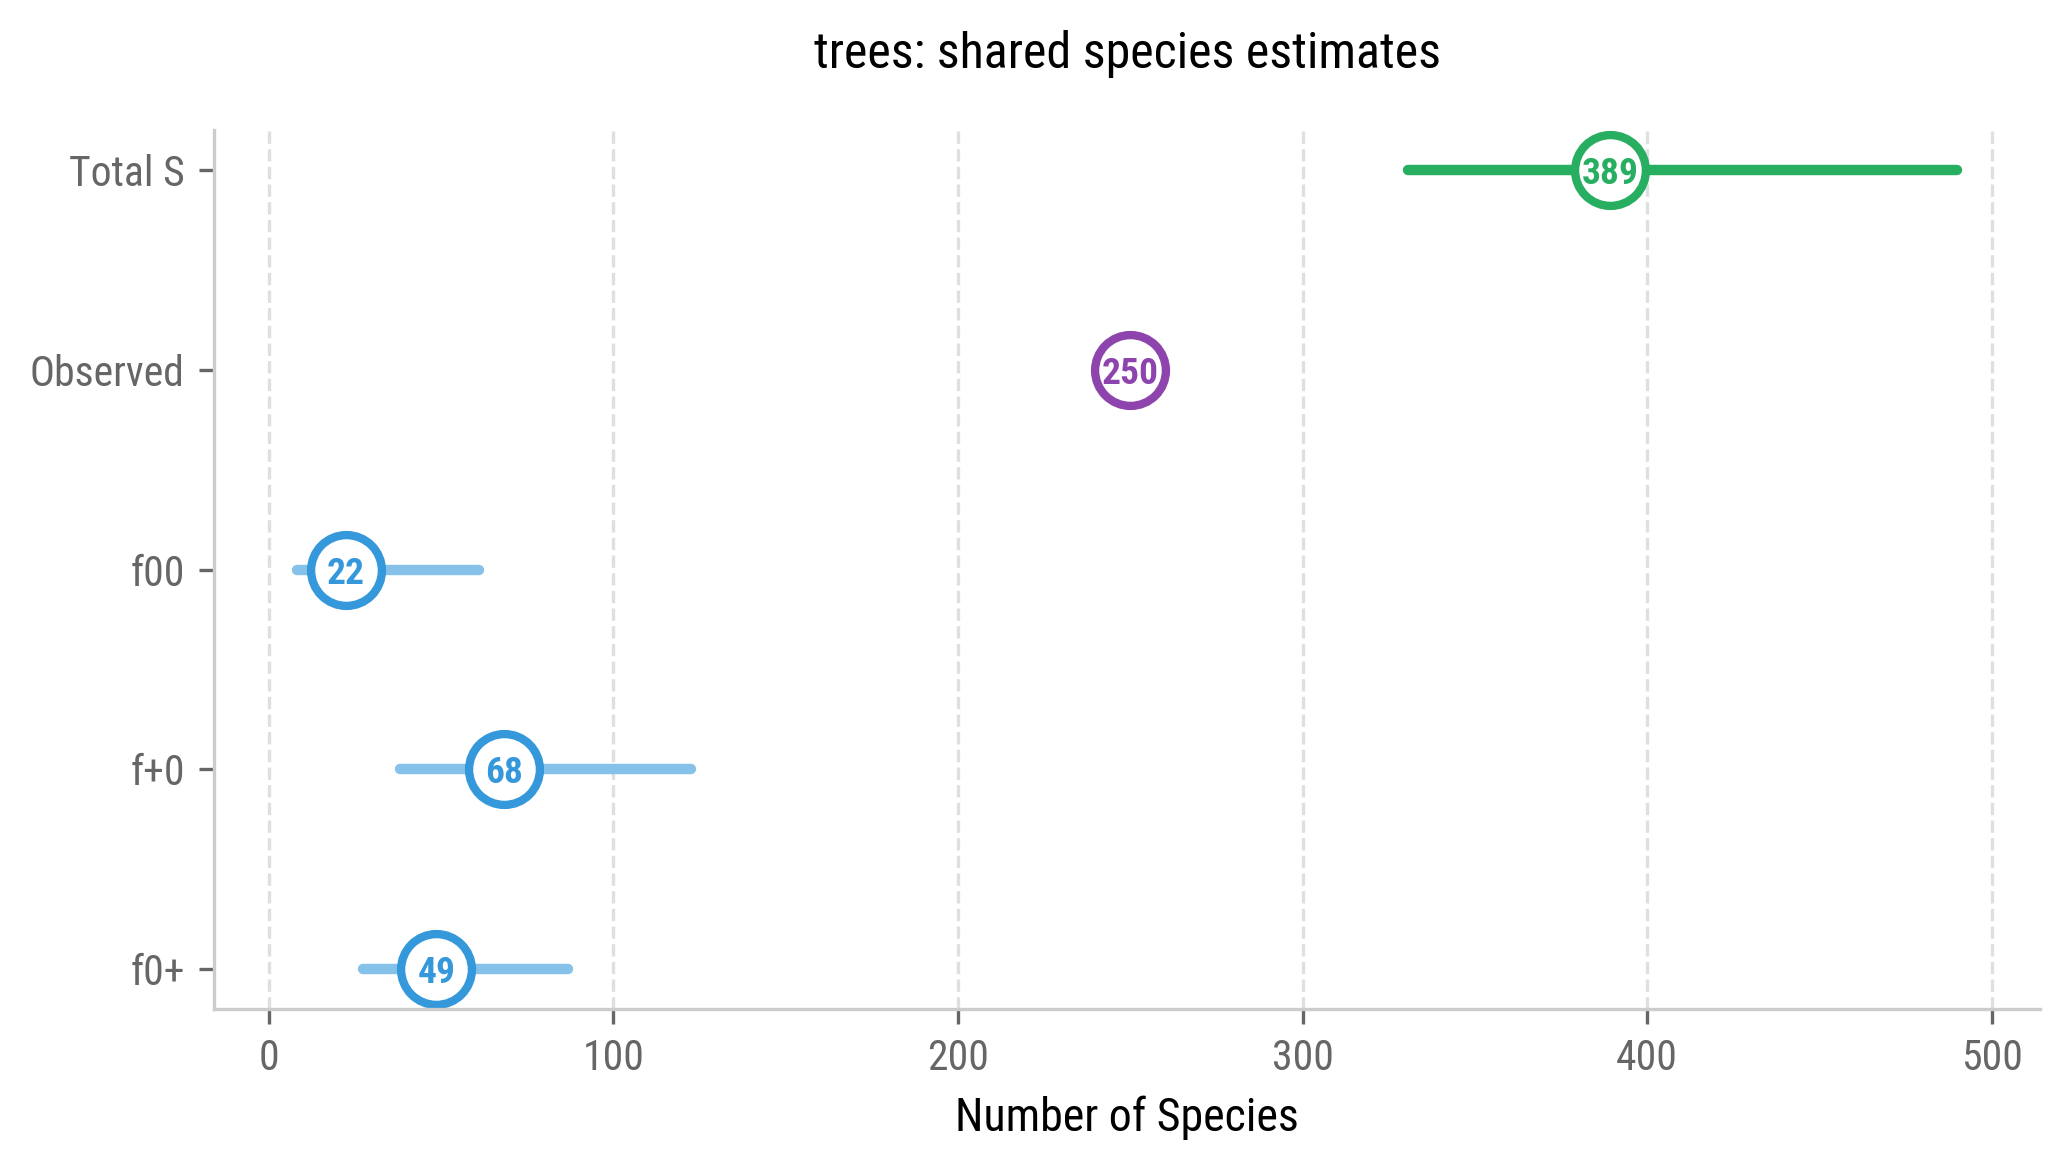

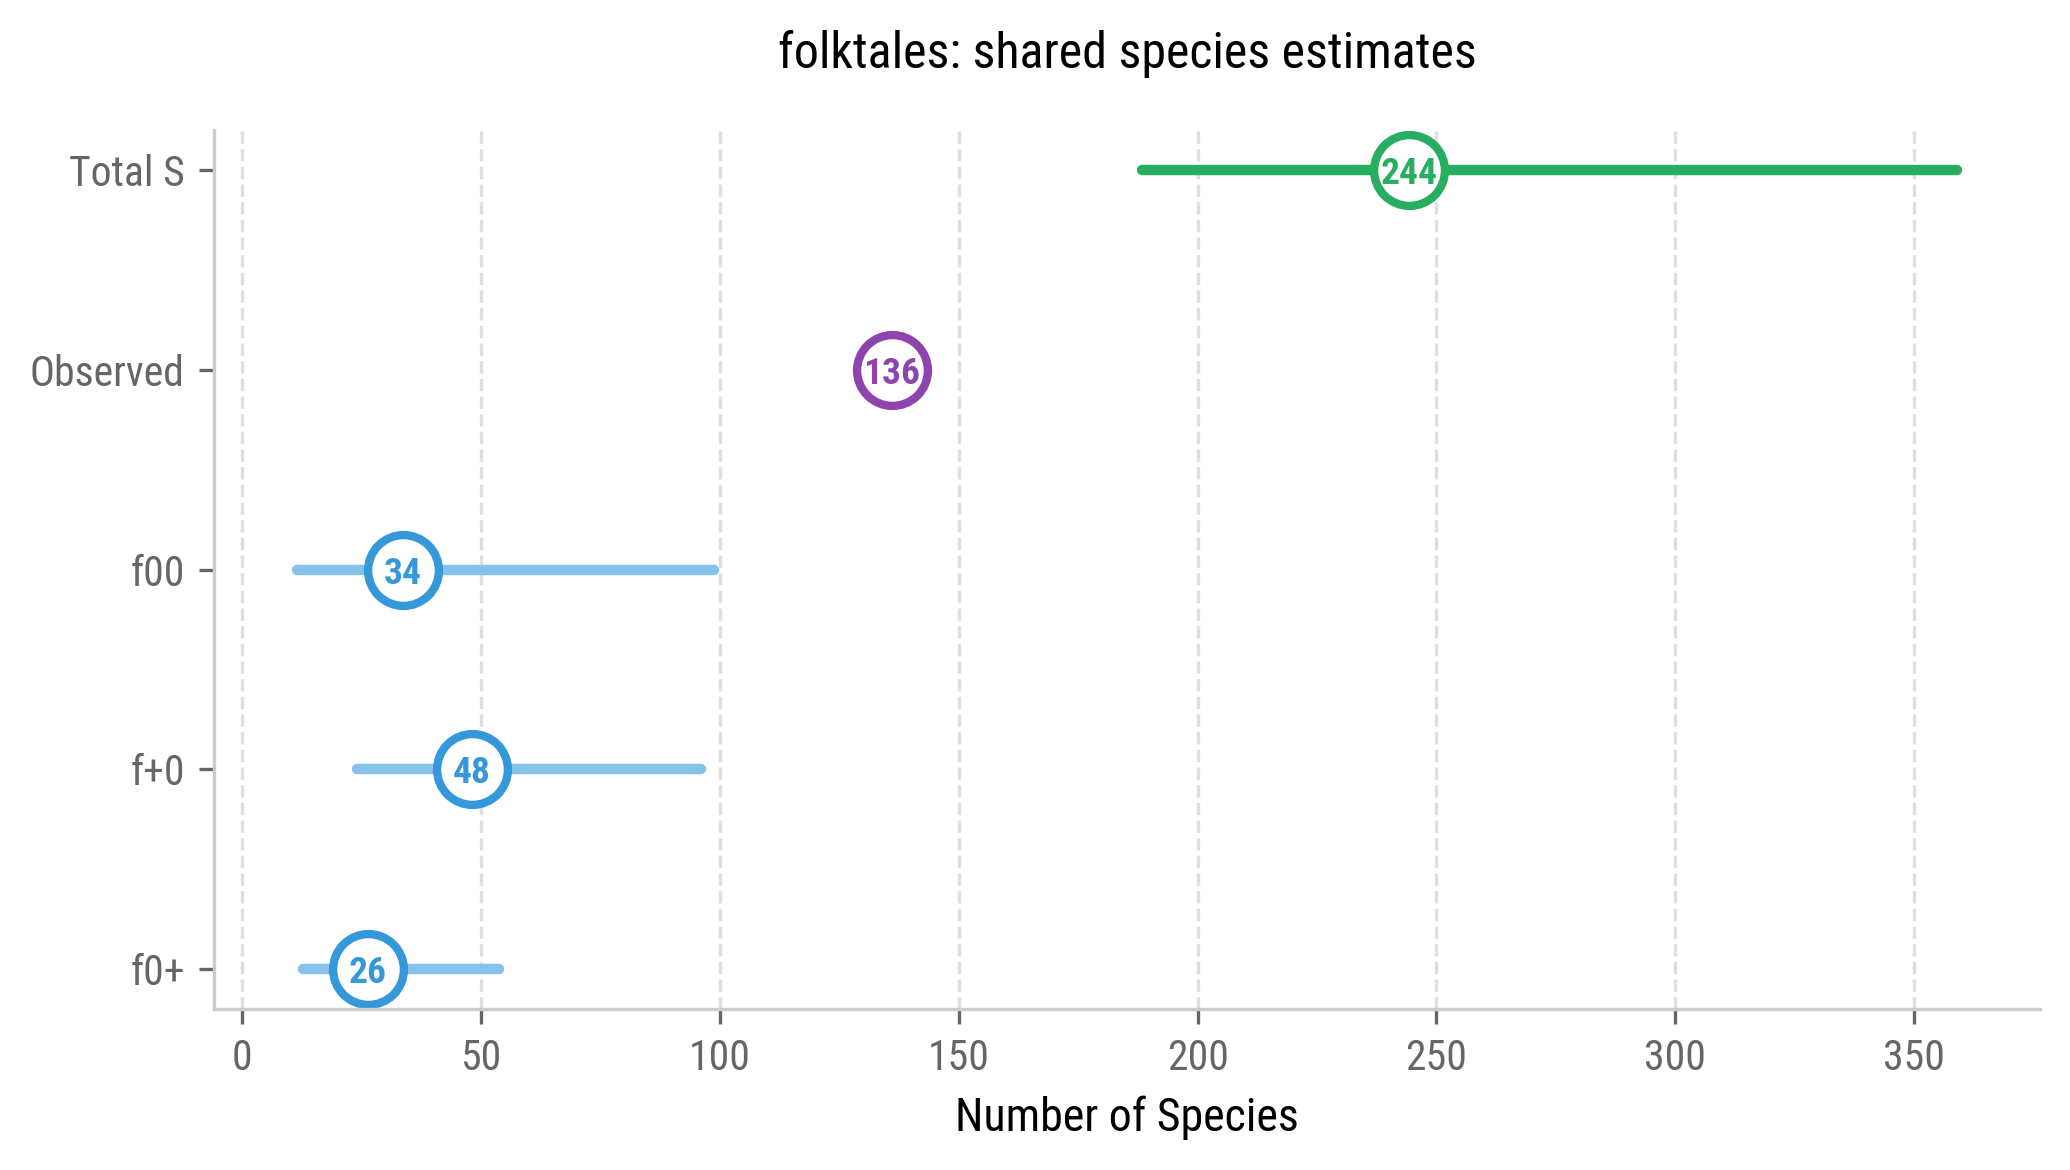

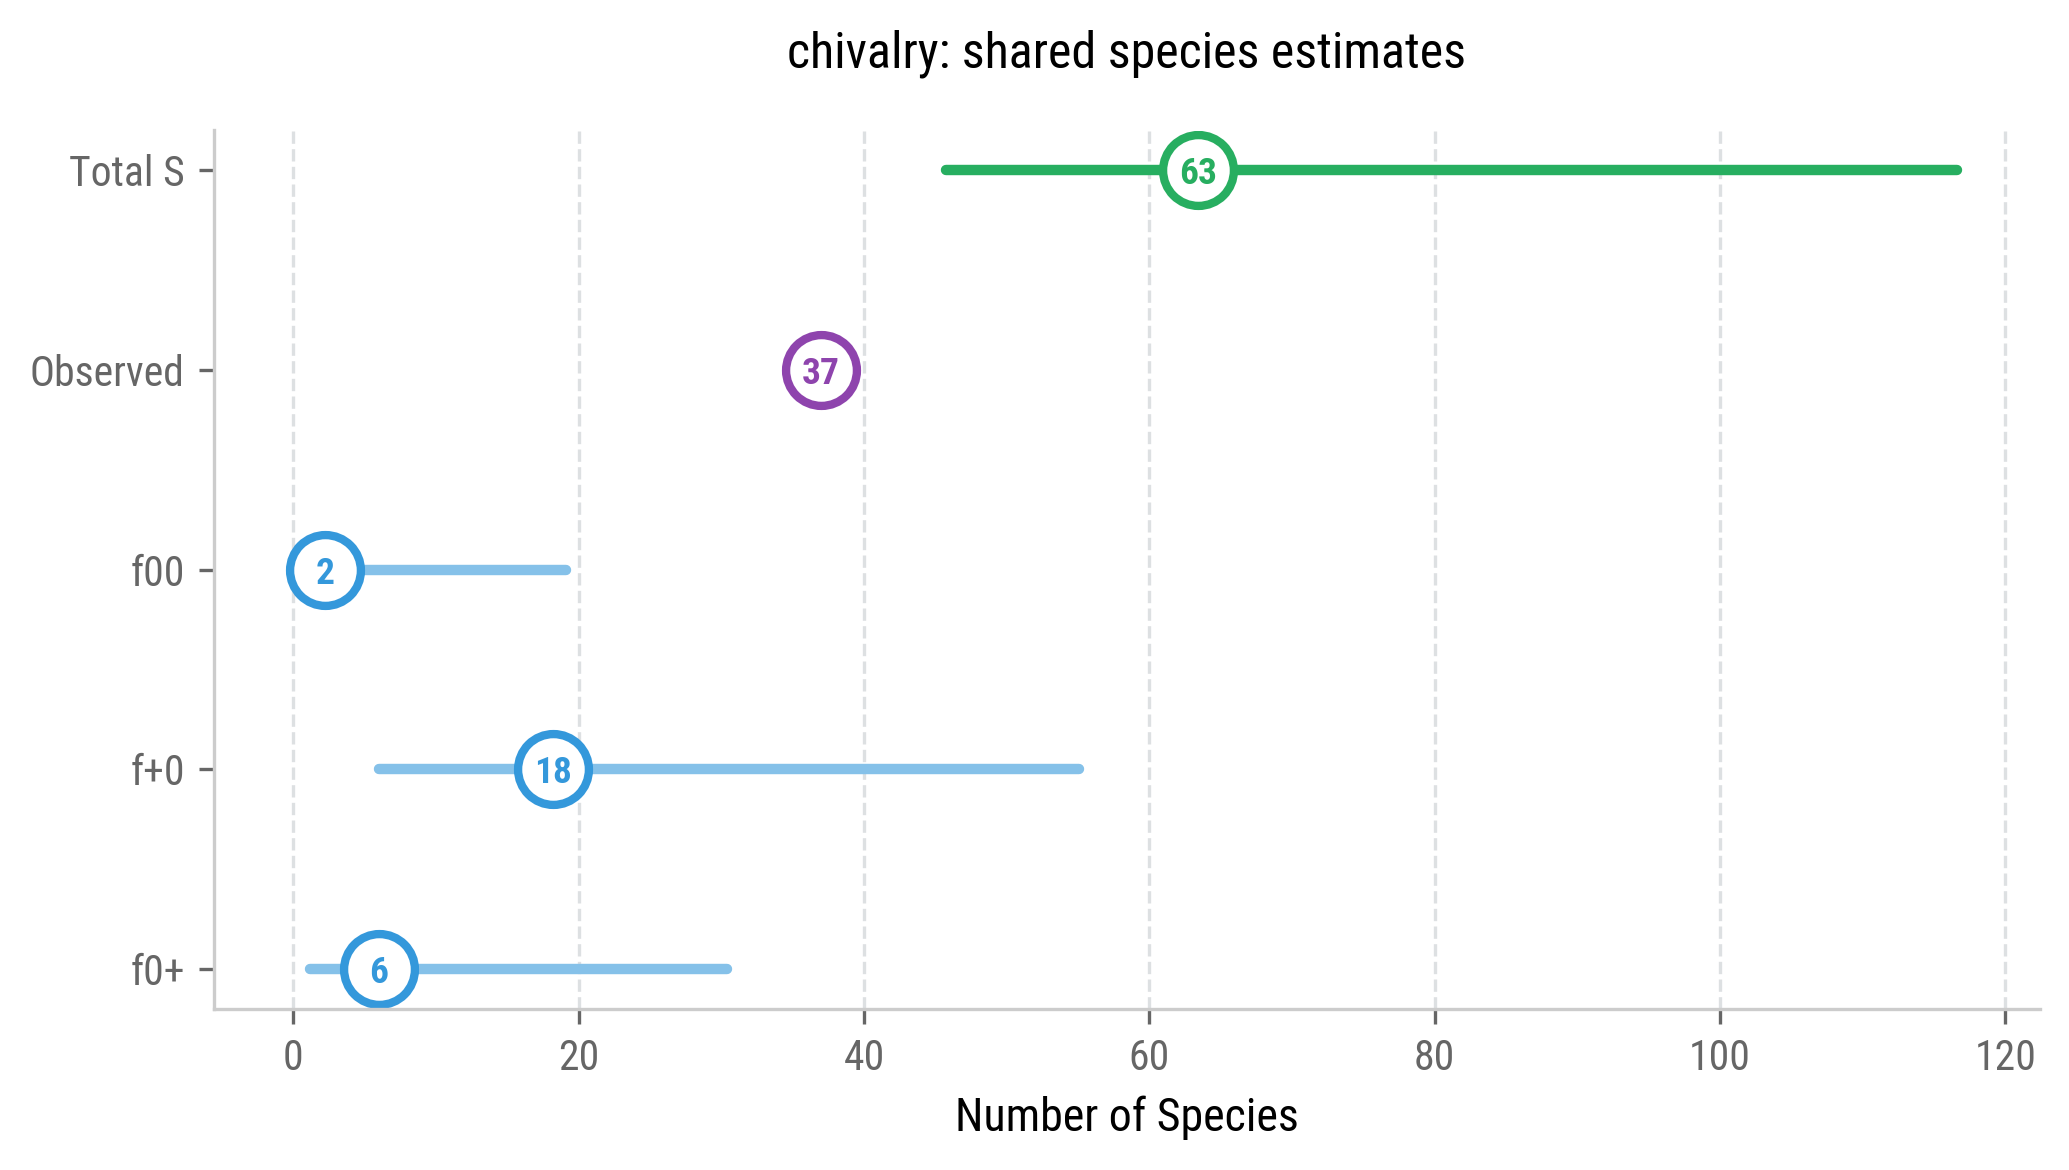

In [16]:
results = chao1_shared_variance_with_components(datasets['trees']['S1'], datasets['trees']['S2'])
fig, ax = plot_shared_species_forest(results, title="trees: shared species estimates")
plt.show()

results = chao1_shared_variance_with_components(datasets['folktales']['S1'], datasets['folktales']['S2'])
fig, ax = plot_shared_species_forest(results, title="folktales: shared species estimates")
plt.show()

results = chao1_shared_variance_with_components(datasets['chivalry']['S1'], datasets['chivalry']['S2'])
fig, ax = plot_shared_species_forest(results, title="chivalry: shared species estimates")
plt.show()


# Confidence Intervals for Shared Species Richness Components

## Overview
We estimate confidence intervals for the total shared species richness (S) and its components (f0+, f+0, f00) using a log-transformation approach that accounts for:
- Non-negativity of estimates
- Right-skewed sampling distributions
- Multiplicative nature of estimation errors

## Mathematical Framework

### For Total S
The variance is estimated using derivatives of the estimator with respect to observed frequencies:

$\text{Var}(S) = \sum_{i,j} \frac{\partial S}{\partial \xi_i} \frac{\partial S}{\partial \xi_j} \text{Cov}(\xi_i, \xi_j)$

where $\xi_i$ represents frequency counts (f11, f1+, f+1, etc.)

The confidence interval is constructed as:

$[D_{12} + t/K, D_{12} + tK]$

where:
- $D_{12}$ is observed shared species
- $t = S - D_{12}$
- $K = \exp(z_{\alpha/2}\sqrt{\ln(1 + \text{SE}^2/t^2)})$
- $z_{\alpha/2}$ is the standard normal quantile

### For Components (f0+, f+0, f00)
For each component C, we use a direct log-normal approximation:

$\ln(C) \pm z_{\alpha/2}\sqrt{\ln(1 + (\text{SE}/C)^2)}$

transformed back to:

$[C/K, CK]$

where $K = \exp(z_{\alpha/2}\sqrt{\ln(1 + (\text{SE}/C)^2)})$

This approach:
1. Ensures non-negative bounds
2. Handles skewness in component distributions
3. Preserves multiplicative error structure

## Bootstrap

In [17]:
import numpy as np

# Probability computation for one assemblage
def bt_prob_abundance(ds):
    x, n, f1, f2 = ds['counts'], ds['n'], ds['f1'], ds['f2']
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for _ in np.arange(int(f0))])))
    return p

# Aligned bootstrap sampling
def aligned_bootstrap_sampling(s1, s2, prob1, prob2, n_bootstrap, random_state=None):
    np.random.seed(random_state)
    n_species = len(prob1)
    
    # Storage for bootstrap samples
    bootstrap_s1 = []
    bootstrap_s2 = []

    for _ in range(n_bootstrap):
        # Sample indices from the range of species
        sampled_indices = np.random.choice(n_species, size=n_species, replace=True)
        
        # Create bootstrap samples based on aligned indices
        boot_s1 = s1[sampled_indices]
        boot_s2 = s2[sampled_indices]
        
        # Append the aligned bootstrap samples
        bootstrap_s1.append(boot_s1)
        bootstrap_s2.append(boot_s2)
    
    return bootstrap_s1, bootstrap_s2


In [ ]:
def Chao1_sharedEstFun(s1, s2):
    D12 = np.sum((s1 > 0) & (s2 > 0))
    idx = (s1 > 0) & (s2 > 0)
    x1_share = s1[idx]
    x2_share = s2[idx]
    f11 = np.sum((x1_share == 1) & (x2_share == 1))
    f1_plus = np.sum((x1_share == 1) & (x2_share >= 1))
    fplus_1 = np.sum((x2_share == 1) & (x1_share >= 1))
    f2_plus = np.sum((x1_share == 2) & (x2_share >= 1))
    fplus_2 = np.sum((x2_share == 2) & (x1_share >= 1))
    if f2_plus == 0 or fplus_2 == 0:
        est = (D12 +
               f11 * f1_plus * fplus_1 / (4 * (f2_plus + 1) * (fplus_2 + 1)) +
               f1_plus * (f1_plus - 1) / (2 * (f2_plus + 1)) +
               fplus_1 * (fplus_1 - 1) / (2 * (fplus_2 + 1)))
    else:
        est = (D12 +
               f11 * f1_plus * fplus_1 / (4 * f2_plus * fplus_2) +
               f1_plus ** 2 / (2 * f2_plus) +
               fplus_1 ** 2 / (2 * fplus_2))
    return est

def Chao1_sharedEst_f0p(s1, s2):
    n1 = np.sum(s1)
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    if f2p > 0:
        f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * f2p))
    else:
        f0p = ((n1 - 1) / n1) * ((f1p ** 2) / 2)
    return f0p

def Chao1_sharedEst_fp0(s1, s2):
    n2 = np.sum(s2)
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    if fp2 > 0:
        fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * fp2))
    else:
        fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / 2)
    return fp0

def Chao1_sharedEst_f00(s1, s2):
    n1 = np.sum(s1)
    n2 = np.sum(s2)
    f11 = np.sum((s1 == 1) & (s2 == 1))
    f22 = np.sum((s1 == 2) & (s2 == 2))
    if f22 > 0:
        f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * f22))
    else:
        f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / 4)
    return f00

def chao1_sharedEstimates(s1, s2):
    est_S = Chao1_sharedEstFun(s1, s2)
    est_f0p = Chao1_sharedEst_f0p(s1, s2)
    est_fp0 = Chao1_sharedEst_fp0(s1, s2)
    est_f00 = Chao1_sharedEst_f00(s1, s2)
    return est_S, est_f0p, est_fp0, est_f00


def chao1_shared_bootstrap(s1, s2, n_bootstrap=1000, conf=0.95, random_state=None, sampling='random'):
    if len(s1) != len(s2):
        raise ValueError("s1 and s2 must be of the same length and aligned.")
    
    np.random.seed(random_state)
    
    bootstrap_S = []
    bootstrap_f0p = []
    bootstrap_fp0 = []
    bootstrap_f00 = []

    for _ in range(n_bootstrap):
        if sampling == 'random':
            # sample existing pairs with replacements:
            n_species = max(len(s1), len(s2))
            sampled_indices = np.random.choice(n_species, size=n_species, replace=True)
            boot_s1 = s1.iloc[sampled_indices]
            boot_s2 = s2.iloc[sampled_indices]
            
        
        est_S, est_f0p, est_fp0, est_f00 = chao1_sharedEstimates(boot_s1, boot_s2)
        
        bootstrap_S.append(est_S)
        bootstrap_f0p.append(est_f0p)
        bootstrap_fp0.append(est_fp0)
        bootstrap_f00.append(est_f00)
    
    lower_percentile = ((1.0 - conf) / 2.0) * 100
    upper_percentile = (conf + (1.0 - conf) / 2.0) * 100
    
    ci_S_lower = np.percentile(bootstrap_S, lower_percentile)
    ci_S_upper = np.percentile(bootstrap_S, upper_percentile)
    
    ci_f0p_lower = np.percentile(bootstrap_f0p, lower_percentile)
    ci_f0p_upper = np.percentile(bootstrap_f0p, upper_percentile)
    
    ci_fp0_lower = np.percentile(bootstrap_fp0, lower_percentile)
    ci_fp0_upper = np.percentile(bootstrap_fp0, upper_percentile)
    
    ci_f00_lower = np.percentile(bootstrap_f00, lower_percentile)
    ci_f00_upper = np.percentile(bootstrap_f00, upper_percentile)
    
    results = {
        "point estimates": {
            "S": round(est_S),
            "f0+": round(est_f0p),
            "f+0": round(est_fp0),
            "f00": round(est_f00)
        },
        "CI": {
            "S": {"lower": round(ci_S_lower), "upper": round(ci_S_upper)},
            "f0+": {"lower": round(ci_f0p_lower), "upper": round(ci_f0p_upper)},
            "f+0": {"lower": round(ci_fp0_lower), "upper": round(ci_fp0_upper)},
            "f00": {"lower": round(ci_f00_lower), "upper": round(ci_f00_upper)}
        }
    }
    
    return results, np.column_stack((bootstrap_S, bootstrap_f0p, bootstrap_fp0, bootstrap_f00))

result = chao1_shared_variance(trees['Edge'], trees['Interior'], conf=confidence_level)
print(result)
result, bootstrap = chao1_shared_bootstrap(trees['Edge'], trees['Interior'], sampling='random',
                                     conf=0.95, n_bootstrap=1000, random_state=42)
print(result)
result, bootstrap = chao1_shared_bootstrap(trees['Edge'], trees['Interior'], sampling='smart',
                                     conf=0.95, n_bootstrap=1000, random_state=42)
print(result)

{'S': 389, 'observed shared': 250, 'f0+': 49, 'f+0': 68, 'f00': 22, 'Estimator': 388.5369369369369, 'Est_s.e.': 39.04810706623067, '95.0 % Lower': 330.46364787298614, '95.0 % Upper': 488.0091443007828}
{'point estimates': {'S': 429, 'f0+': 83, 'f+0': 56, 'f00': 36}, 'CI': {'S': {'lower': 328, 'upper': 489}, 'f0+': {'lower': 26, 'upper': 85}, 'f+0': {'lower': 38, 'upper': 126}, 'f00': {'lower': 7, 'upper': 75}}}
{'point estimates': {'S': 425, 'f0+': 0, 'f+0': 0, 'f00': 0}, 'CI': {'S': {'lower': 425, 'upper': 425}, 'f0+': {'lower': 0, 'upper': 0}, 'f+0': {'lower': 0, 'upper': 0}, 'f00': {'lower': 0, 'upper': 0}}}


In [ ]:
result, bootstrap = chao1_shared_bootstrap(folktales['drachten'], folktales['harkema'], conf=0.95, n_bootstrap=10000, random_state=42)
print(result)

{'point estimates': {'S': 246, 'f0+': 29, 'f+0': 54, 'f00': 45}, 'CI': {'S': {'lower': 176, 'upper': 333}, 'f0+': {'lower': 12, 'upper': 56}, 'f+0': {'lower': 23, 'upper': 101}, 'f00': {'lower': 11, 'upper': 169}}}


In [ ]:
result, bootstrap = chao1_shared_bootstrap(chiv['mfr'], chiv['mdu'], conf=0.95, n_bootstrap=10000, random_state=42)
result

{'point estimates': {'S': 79, 'f0+': 4, 'f+0': 36, 'f00': 6},
 'CI': {'S': {'lower': 40, 'upper': 155},
  'f0+': {'lower': 0, 'upper': 40},
  'f+0': {'lower': 5, 'upper': 72},
  'f00': {'lower': 0, 'upper': 9}}}

In [ ]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Union, List

def chao1_shared_estimates(s1: pd.Series, s2: pd.Series) -> Tuple[float, float, float, float]:
    """
    Calculate Chao1 shared species estimates for two assemblages.
    
    Args:
        s1: Species abundances in first assemblage
        s2: Species abundances in second assemblage
        
    Returns:
        Tuple of (shared species estimate, f0+, f+0, f00)
    """
    # Shared species calculations
    shared_mask = (s1 > 0) & (s2 > 0)
    x1_share = s1[shared_mask]
    x2_share = s2[shared_mask]
    
    # Basic counts
    D12 = np.sum(shared_mask)
    f11 = np.sum((x1_share == 1) & (x2_share == 1))
    f1_plus = np.sum((x1_share == 1) & (x2_share >= 1))
    fplus_1 = np.sum((x2_share == 1) & (x1_share >= 1))
    f2_plus = np.sum((x1_share == 2) & (x2_share >= 1))
    fplus_2 = np.sum((x2_share == 2) & (x1_share >= 1))
    
    # Calculate shared species estimate
    if f2_plus == 0 or fplus_2 == 0:
        est_S = (D12 +
                f11 * f1_plus * fplus_1 / (4 * (f2_plus + 1) * (fplus_2 + 1)) +
                f1_plus * (f1_plus - 1) / (2 * (f2_plus + 1)) +
                fplus_1 * (fplus_1 - 1) / (2 * (fplus_2 + 1)))
    else:
        est_S = (D12 +
                f11 * f1_plus * fplus_1 / (4 * f2_plus * fplus_2) +
                f1_plus ** 2 / (2 * f2_plus) +
                fplus_1 ** 2 / (2 * fplus_2))
    
    # Calculate f0+
    n1 = np.sum(s1)
    f1p = np.sum((s1 == 1) & (s2 >= 1))
    f2p = np.sum((s1 == 2) & (s2 >= 1))
    est_f0p = ((n1 - 1) / n1) * ((f1p ** 2) / (2 * (f2p if f2p > 0 else 1)))
    
    # Calculate f+0
    n2 = np.sum(s2)
    fp1 = np.sum((s1 >= 1) & (s2 == 1))
    fp2 = np.sum((s1 >= 1) & (s2 == 2))
    est_fp0 = ((n2 - 1) / n2) * ((fp1 ** 2) / (2 * (fp2 if fp2 > 0 else 1)))
    
    # Calculate f00
    f22 = np.sum((s1 == 2) & (s2 == 2))
    est_f00 = ((n1 - 1) / n1) * ((n2 - 1) / n2) * ((f11 ** 2) / (4 * (f22 if f22 > 0 else 1)))
    
    return est_S, est_f0p, est_fp0, est_f00

def chao1_shared_bootstrap(
    s1: pd.Series,
    s2: pd.Series,
    n_bootstrap: int = 1000,
    conf: float = 0.95,
    random_state: Union[int, None] = None,
    sampling: str = 'random'
) -> Tuple[Dict, np.ndarray]:
    """
    Perform bootstrap estimation of shared species richness with confidence intervals.
    
    Args:
        s1: Species abundances in first assemblage
        s2: Species abundances in second assemblage
        n_bootstrap: Number of bootstrap iterations
        conf: Confidence level (0-1)
        random_state: Random seed for reproducibility
        sampling: Sampling strategy ('random' or 'parametric')
        
    Returns:
        Tuple of (results dictionary, bootstrap samples array)
    """
    if len(s1) != len(s2):
        raise ValueError("s1 and s2 must be of the same length and aligned.")
    
    if not 0 < conf < 1:
        raise ValueError("Confidence level must be between 0 and 1")
        
    if sampling not in ['random', 'parametric']:
        raise ValueError("Sampling must be either 'random' or 'parametric'")
    
    np.random.seed(random_state)
    n_species = len(s1)
    
    # Storage for bootstrap results
    bootstrap_results = np.zeros((n_bootstrap, 4))
    
    # Get initial estimates
    est_S, est_f0p, est_fp0, est_f00 = chao1_shared_estimates(s1, s2)
    
    # Perform bootstrap
    for i in range(n_bootstrap):
        if sampling == 'random':
            # Simple random sampling with replacement
            indices = np.random.choice(n_species, size=n_species, replace=True)
            boot_s1 = s1.iloc[indices]
            boot_s2 = s2.iloc[indices]
        else:  # parametric bootstrap
            # TODO: Implement parametric bootstrap sampling if needed
            raise NotImplementedError("Parametric bootstrap not yet implemented")
            
        bootstrap_results[i, :] = chao1_shared_estimates(boot_s1, boot_s2)
    
    # Calculate confidence intervals
    alpha = 1 - conf
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    
    ci_bounds = np.percentile(bootstrap_results, [lower_percentile, upper_percentile], axis=0)
    
    # Format results
    metric_names = ['S', 'f0+', 'f+0', 'f00']
    point_estimates = [est_S, est_f0p, est_fp0, est_f00]
    
    results = {
        "point_estimates": {
            name: round(est) for name, est in zip(metric_names, point_estimates)
        },
        "confidence_intervals": {
            name: {
                "lower": round(lower),
                "upper": round(upper)
            } for name, lower, upper in zip(metric_names, ci_bounds[0], ci_bounds[1])
        },
        "bootstrap_info": {
            "n_bootstrap": n_bootstrap,
            "confidence_level": conf,
            "sampling_method": sampling
        }
    }
    
    return results, bootstrap_results

result = chao1_shared_variance(trees['Edge'], trees['Interior'], conf=confidence_level)
print(result)
result, bootstrap = chao1_shared_bootstrap(trees['Edge'], trees['Interior'], sampling='random',
                                     conf=0.95, n_bootstrap=1000, random_state=42)
print(result)
#result, bootstrap = chao1_shared_bootstrap(trees['Edge'], trees['Interior'], sampling='smart',
#                                     conf=0.95, n_bootstrap=1000, random_state=42)
#print(result)





{'S': 389, 'observed shared': 250, 'f0+': 49, 'f+0': 68, 'f00': 22, 'Estimator': 388.5369369369369, 'Est_s.e.': 39.04810706623067, '95.0 % Lower': 330.46364787298614, '95.0 % Upper': 488.0091443007828}
{'point_estimates': {'S': 389, 'f0+': 49, 'f+0': 68, 'f00': 22}, 'confidence_intervals': {'S': {'lower': 328, 'upper': 489}, 'f0+': {'lower': 26, 'upper': 85}, 'f+0': {'lower': 38, 'upper': 126}, 'f00': {'lower': 7, 'upper': 75}}, 'bootstrap_info': {'n_bootstrap': 1000, 'confidence_level': 0.95, 'sampling_method': 'random'}}


In [ ]:
def plot_estimates(results, boot_estimates):
    quantities = ['S', 'f0+', 'f+0', 'f00']
    quantity_names = {
        'S': 'Shared Richness (S)',
        'f0+': 'Unobserved in S1 (f0+)',
        'f+0': 'Unobserved in S2 (f+0)',
        'f00': 'Unobserved in both (f00)'
    }
    quantity_indices = {
        'S': 0,
        'f0+': 1,
        'f+0': 2,
        'f00': 3
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    axes = axes.flatten()
    handles, labels = [], []
    
    # Vibrant color palette
    hist_color = '#3498db'  # Bright blue
    kde_color = '#2c3e50'   # Dark blue-gray
    mean_color = '#2ecc71'  # Bright green
    ci_color = '#e74c3c'    # Bright red
    
    for idx, quantity in enumerate(quantities):
        boot_vals = boot_estimates[:, quantity_indices[quantity]]
        point_estimate = results["point estimates"][quantity]
        mean_boot = np.mean(boot_vals)
        
        ci_lower = results["CI"][quantity]["lower"]
        ci_upper = results["CI"][quantity]["upper"]
        
        ax = axes[idx]
        
        cutoff = 2
        Q1 = np.percentile(boot_vals, 10)
        Q3 = np.percentile(boot_vals, 90)
        IQR = Q3 - Q1
        lower_bound = Q1 - cutoff * IQR
        upper_bound = Q3 + cutoff * IQR
        
        filtered_vals = boot_vals[(boot_vals >= lower_bound) & (boot_vals <= upper_bound)]
        
        pd.Series(boot_vals).plot(kind='hist', density=True, bins=50, 
                                       color=hist_color, edgecolor='white', alpha=0.7, 
                                       ax=ax)
        pd.Series(boot_vals).plot(kind='kde', bw_method=0.5, color=kde_color, linewidth=2, ax=ax)
        
        #ax.set_xlim(np.min(filtered_vals), np.max(filtered_vals))
        ax.set_xlim(-1, np.max(filtered_vals))
        
        #line1, = ax.plot([], [], color=mean_color, linestyle='-', linewidth=2, label=f'Mean Bootstrap')
        line2, = ax.plot([], [], color=ci_color, linestyle='dotted', linewidth=2, label=f'95% CI Lower')
        line3, = ax.plot([], [], color=ci_color, linestyle='dotted', linewidth=2, label=f'95% CI Upper')
        line4, = ax.plot([], [], color='purple', linestyle='--', linewidth=2, label=f'Point Estimate')
        
        if idx == 1:
            handles.extend([line2, line3, line4])
            labels.extend([line2.get_label(), line3.get_label(), line4.get_label()])
        
        #ax.axvline(mean_boot, color=mean_color, linestyle='-', linewidth=2)
        ax.axvline(ci_lower, color=ci_color, linestyle='dotted', linewidth=2)
        ax.axvline(ci_upper, color=ci_color, linestyle='dotted', linewidth=2)
        ax.axvline(point_estimate, color='purple', linestyle='--', linewidth=2)
        
        
        if idx == 0:
            ax.set_ylabel('Density')
        else:
            ax.set_ylabel(None)
        ax.set_title(f'{quantity_names[quantity]}')
    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(handles), frameon=False)
    plt.tight_layout()
    plt.show()

### Results

{'point estimates': {'S': 435, 'f0+': 62, 'f+0': 102, 'f00': 17}, 'CI': {'S': {'lower': 326, 'upper': 495}, 'f0+': {'lower': 26, 'upper': 87}, 'f+0': {'lower': 37, 'upper': 127}, 'f00': {'lower': 7, 'upper': 80}}}


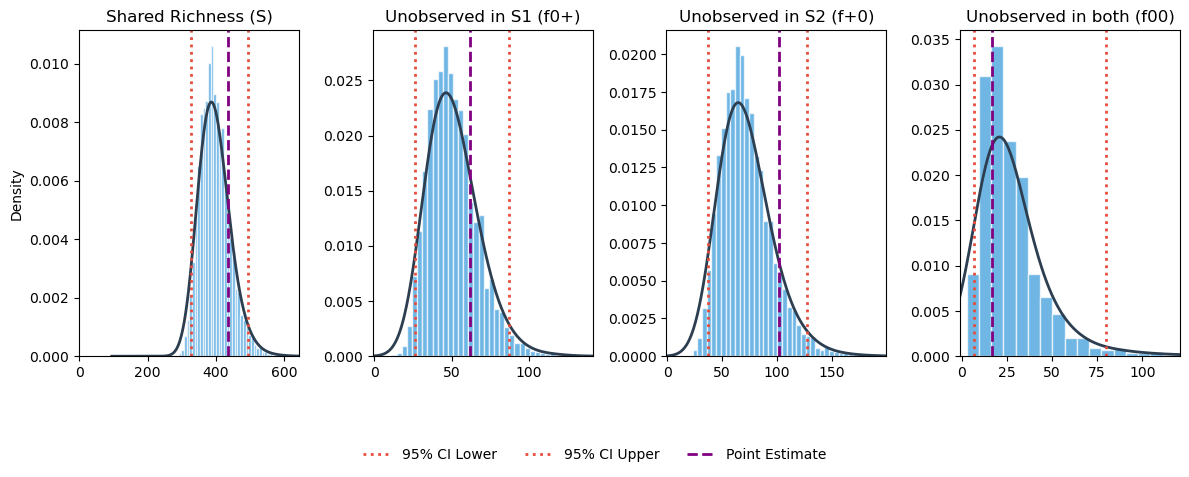

In [ ]:
results, boot_estimates = chao1_shared_bootstrap(trees['Edge'], trees['Interior'], conf=0.95, n_bootstrap=10000, random_state=42)
print(results)
plot_estimates(results, boot_estimates)

{'point estimates': {'S': 246, 'f0+': 29, 'f+0': 54, 'f00': 45}, 'CI': {'S': {'lower': 176, 'upper': 333}, 'f0+': {'lower': 12, 'upper': 56}, 'f+0': {'lower': 23, 'upper': 101}, 'f00': {'lower': 11, 'upper': 169}}}


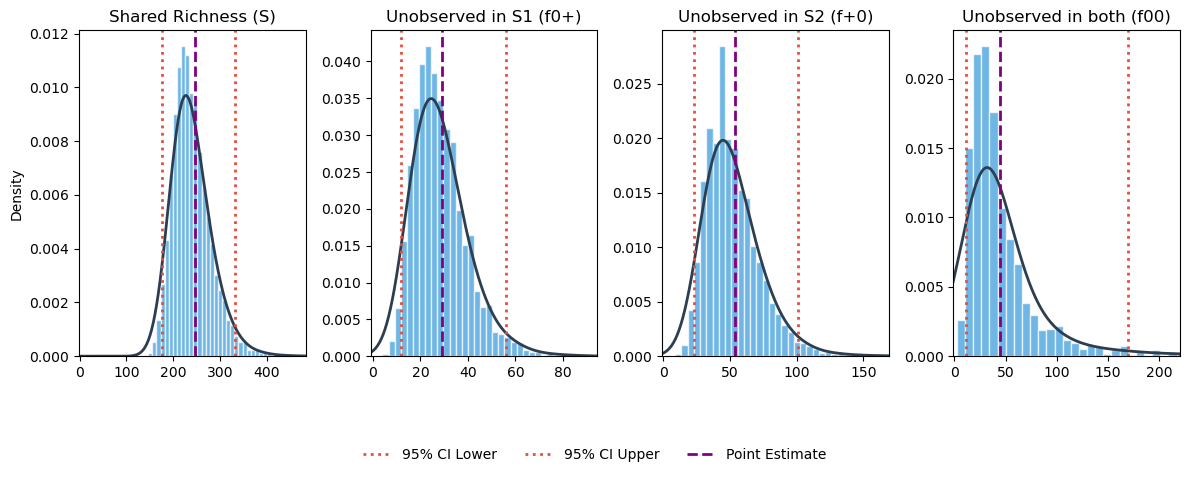

In [ ]:
results, boot_estimates = chao1_shared_bootstrap(folktales['drachten'], folktales['harkema'], conf=0.95, n_bootstrap=10000, random_state=42)
print(results)
plot_estimates(results, boot_estimates)

{'point estimates': {'S': 79, 'f0+': 4, 'f+0': 36, 'f00': 6}, 'CI': {'S': {'lower': 40, 'upper': 155}, 'f0+': {'lower': 0, 'upper': 40}, 'f+0': {'lower': 5, 'upper': 72}, 'f00': {'lower': 0, 'upper': 9}}}


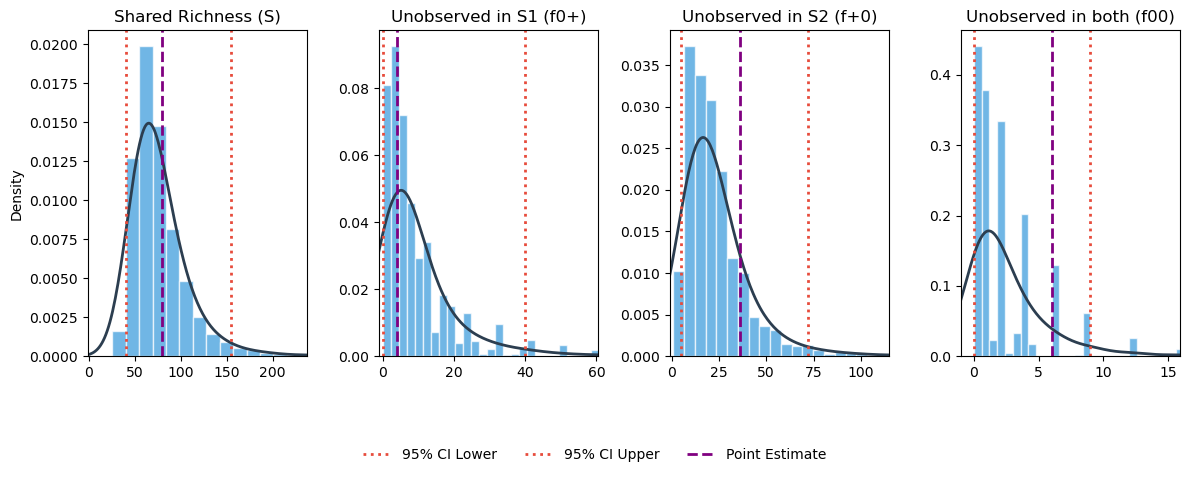

In [ ]:
results, boot_estimates = chao1_shared_bootstrap(chiv['mfr'], chiv['mdu'], conf=0.95, n_bootstrap=10000, random_state=42)
print(results)
plot_estimates(results, boot_estimates)